# Import important libraries and define needed functions and variables

In [1]:
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay

In [2]:
#function to make prediction from probability
def predict(a,thres=0.5):
    if a>= thres:
        return 1
    else:
        return 0

In [3]:
# Batch size
batch_size = 32
# image height
img_height = 180
# image width
img_width = 180

# Data preprocessing

In [4]:
#get data from folders
data = []
folders = ['fresh_peaches_done',
 'fresh_pomegranates_done',
 'fresh_strawberries_done',
 'rotten_peaches_done',
 'rotten_pomegranates_done',
 'rotten_strawberries_done'
          ]
for folder in folders:
    if folder.split("_")[0] == 'fresh':
        fresh = 1
    else:
        fresh = 0
    if  folder.split("_")[1] == "peaches":
        class_name = 0
    elif folder.split("_")[1] == "pomegranates":
        class_name = 1
    else:
        class_name = 2
    for file in os.listdir('data/'+folder):
        img = cv2.imread('data/'+folder+"/"+file)      
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     #convert to RGB   
        img = cv2.resize(img, (img_height, img_width)) #resize images
        data.append((img, class_name,fresh))  

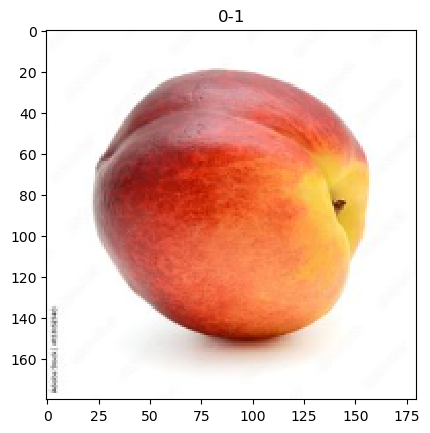

In [5]:
#plot the first image in the dataset
plt.imshow(data[0][0], interpolation='nearest')
plt.title(str(data[0][1])+ "-"+str(data[0][2]))
plt.show()

In [6]:
#Split data to X and y. There are 2 target datasets to build 2 different models
X = np.array([i[0] for i in data])
y_class = np.array([i[1] for i in data])
y_fresh = np.array([i[2] for i in data])
print(X.shape)
print(y_class.shape)
print(y_fresh.shape)

(1585, 180, 180, 3)
(1585,)
(1585,)


In [9]:
#convert to one-hot
y_class = tf.keras.utils.to_categorical(y_class)
y_class.shape

(1585, 3)

In [11]:
#train-test split
X_train_class,X_test_class,y_train_class,y_test_class = train_test_split(X,y_class,random_state=42,test_size=0.2)
X_train_fresh,X_test_fresh,y_train_fresh,y_test_fresh = train_test_split(X,y_fresh,random_state=42,test_size=0.2)

# Train model to detect fresh or rotten

In [58]:
#set learning rate schedule: after 10 epochs, learning rate will decrease gradually
def scheduler(epoch, lr):
    if epoch < 10:
        return lr  
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)

In [59]:
#define the model
model_fresh = Sequential([
    # rescaling layer
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    #convolution layers
      layers.Conv2D(32, (3,3), activation='relu'),
      layers.AveragePooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.AveragePooling2D((2,2)),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.AveragePooling2D((2,2)),
      layers.Conv2D(256, (3,3), activation='relu'),
      layers.AveragePooling2D((2,2)),
      layers.Conv2D(512, (3,3), activation='relu'),
      layers.AveragePooling2D((2,2)),
    #flatten layer
      layers.Flatten(),
    #dense layers
      layers.Dense(128, activation='relu'),
      layers.Dense(1, activation='sigmoid')
])

In [60]:
#compile the model
model_fresh.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [61]:
#model summary
model_fresh.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 average_pooling2d_18 (Aver  (None, 89, 89, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_24 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 average_pooling2d_19 (Aver  (None, 43, 43, 64)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_25 (Conv2D)          (None, 41, 41, 128)      

In [62]:
#train model with 25 epochs
epochs=30
history = model_fresh.fit(
                    X_train_fresh,
                    y_train_fresh,
                    validation_data=(X_test_fresh,y_test_fresh),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks= lr_scheduler

)

Epoch 1/30
40/40 [==============================] - 19s 445ms/step - loss: 0.6024 - accuracy: 0.6735 - val_loss: 0.5135 - val_accuracy: 0.7666 - lr: 5.0000e-04
Epoch 2/30
40/40 [==============================] - 17s 419ms/step - loss: 0.4900 - accuracy: 0.7871 - val_loss: 0.4210 - val_accuracy: 0.8328 - lr: 5.0000e-04
Epoch 3/30
40/40 [==============================] - 17s 424ms/step - loss: 0.4388 - accuracy: 0.7973 - val_loss: 0.3764 - val_accuracy: 0.8454 - lr: 5.0000e-04
Epoch 4/30
40/40 [==============================] - 17s 436ms/step - loss: 0.4083 - accuracy: 0.8210 - val_loss: 0.3886 - val_accuracy: 0.8233 - lr: 5.0000e-04
Epoch 5/30
40/40 [==============================] - 17s 435ms/step - loss: 0.3917 - accuracy: 0.8304 - val_loss: 0.3760 - val_accuracy: 0.8170 - lr: 5.0000e-04
Epoch 6/30
40/40 [==============================] - 17s 436ms/step - loss: 0.3599 - accuracy: 0.8391 - val_loss: 0.3368 - val_accuracy: 0.8801 - lr: 5.0000e-04
Epoch 7/30
40/40 [======================

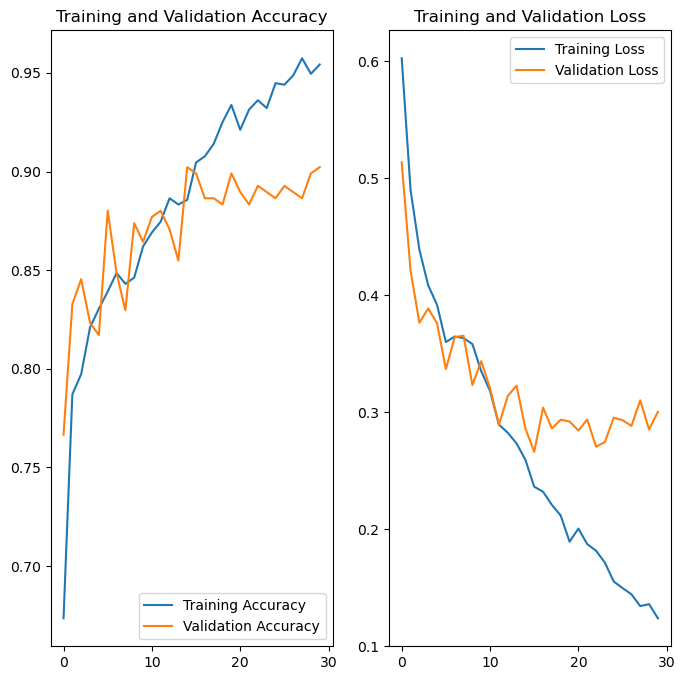

In [63]:
#get train accuracy in history
acc = history.history['accuracy']
#get validation accuracy
val_acc = history.history['val_accuracy']
# get train loss 
loss = history.history['loss']
#get validation loss
val_loss = history.history['val_loss']

epochs_range = range(epochs)
# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plot loss
plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
#predict model with test data
y_pred_fresh = model_fresh.predict(X_test_fresh)
y_pred_fresh = np.array([predict(y_pred_fresh[i]) for i in range(y_pred_fresh.shape[0])])

10/10 [==============================] - 8s 715ms/step


In [65]:
#get accuracy
accuracy_score(y_test_fresh,y_pred_fresh)

0.9022082018927445

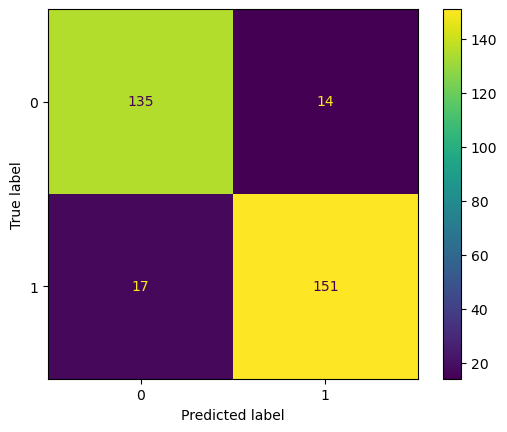

In [66]:
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_fresh,y_pred_fresh)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model_aug = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
      layers.Conv2D(32, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(1, activation='sigmoid')
])

#compile the model
model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_aug.summary()

epochs=15
history_aug = model_aug.fit(
                    X_train_fresh,
                    y_train_fresh,
                    validation_split=0.2,
                    batch_size=batch_size,
                    epochs=epochs
                    
)

In [67]:
#Try with different threshold (k) to see if adjusting the threshold can help to reduce number of FN cases
y_pred_fresh = model_fresh.predict(X_test_fresh)
score = []
for k in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    y_pred_thr = np.array([predict(y_pred_fresh[i],k) for i in range(y_pred_fresh.shape[0])])
    acc = accuracy_score(y_test_fresh,y_pred_thr)
    FN = cf_matrix = confusion_matrix(y_test_fresh, y_pred_thr,labels=np.unique(y_test_fresh))[1,0]
    FP = cf_matrix = confusion_matrix(y_test_fresh, y_pred_thr,labels=np.unique(y_test_fresh))[0,1]
    score.append([k,acc,FN,FP])

10/10 [==============================] - 7s 648ms/step


In [68]:
score

[[0.1, 0.8643533123028391, 8, 35],
 [0.2, 0.889589905362776, 13, 22],
 [0.3, 0.8927444794952681, 15, 19],
 [0.4, 0.8990536277602523, 15, 17],
 [0.5, 0.9022082018927445, 17, 14],
 [0.6, 0.889589905362776, 23, 12],
 [0.7, 0.8832807570977917, 28, 9],
 [0.8, 0.8738170347003155, 32, 8],
 [0.9, 0.8485804416403786, 44, 4],
 [1, 0.47634069400630913, 166, 0]]

Text(0.5, 1.0, 'FP cases with different threshold')

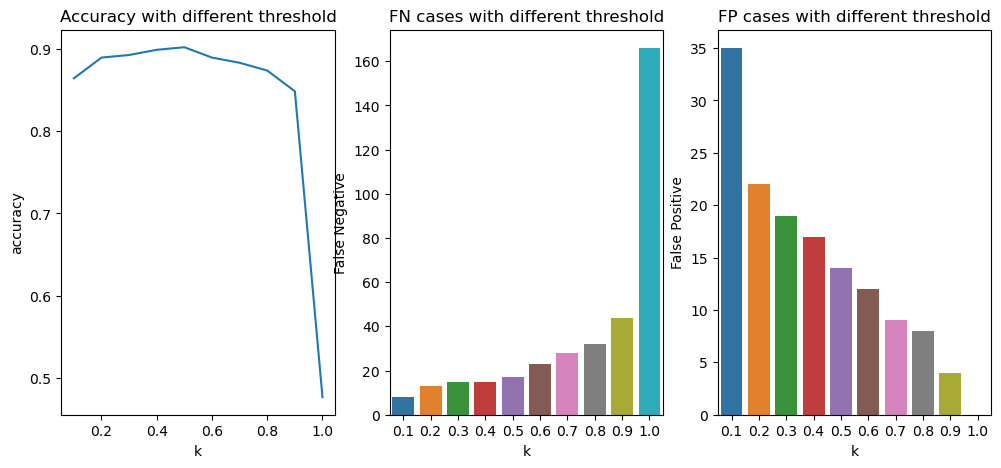

In [69]:
#Get score dataframe
score = pd.DataFrame(data=score,columns=['k','accuracy','False Negative','False Positive'])
fig,ax = plt.subplots(1,3,figsize=(12,5))
#Plot accuracy by different threshold
sns.lineplot(data=score,x='k',y='accuracy',ax=ax[0])
ax[0].set_title("Accuracy with different threshold")
#Plot number of FN cases by different threshold
sns.barplot(data=score,x='k',y='False Negative',ax=ax[1])
ax[1].set_title("FN cases with different threshold")
#Plot number of PN cases by different threshold
sns.barplot(data=score,x='k',y='False Positive',ax=ax[2])
ax[2].set_title("FP cases with different threshold")

In [70]:
#save model
model_fresh.save("fresh_prediction_ver4.keras")

# Train model for fruit type classification

In [31]:
#set data agumenation layer
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [32]:
#define the model
model_class = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      data_augmentation,
      layers.Conv2D(32, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2),padding='SAME'),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2),padding='SAME'),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2),padding='SAME'),
      layers.Conv2D(256, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2),padding='SAME'),
      layers.Conv2D(512, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2),padding='SAME'),
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      #layers.Dense(128, activation='relu'),
      layers.Dense(3, activation='softmax')
])

In [33]:
#compile the model
model_class.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [34]:
#train model with 40 epochs
epochs=40
history = model_class.fit(
                    X_train_class,
                    y_train_class,
                    validation_data=(X_test_class,y_test_class),
                    epochs=epochs,
                    callbacks= lr_scheduler
)

Epoch 1/40
40/40 [==============================] - 21s 508ms/step - loss: 1.0849 - accuracy: 0.4203 - val_loss: 1.0418 - val_accuracy: 0.5237 - lr: 0.0010
Epoch 2/40
40/40 [==============================] - 19s 481ms/step - loss: 0.9641 - accuracy: 0.5473 - val_loss: 0.9495 - val_accuracy: 0.4606 - lr: 0.0010
Epoch 3/40
40/40 [==============================] - 19s 476ms/step - loss: 0.8885 - accuracy: 0.5639 - val_loss: 0.8195 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 4/40
40/40 [==============================] - 21s 527ms/step - loss: 0.8102 - accuracy: 0.5820 - val_loss: 0.8419 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 5/40
40/40 [==============================] - 21s 528ms/step - loss: 0.7315 - accuracy: 0.6285 - val_loss: 0.9873 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 6/40
40/40 [==============================] - 21s 523ms/step - loss: 0.6879 - accuracy: 0.6751 - val_loss: 0.6429 - val_accuracy: 0.6435 - lr: 0.0010
Epoch 7/40
40/40 [==============================] - 20s 496ms/st

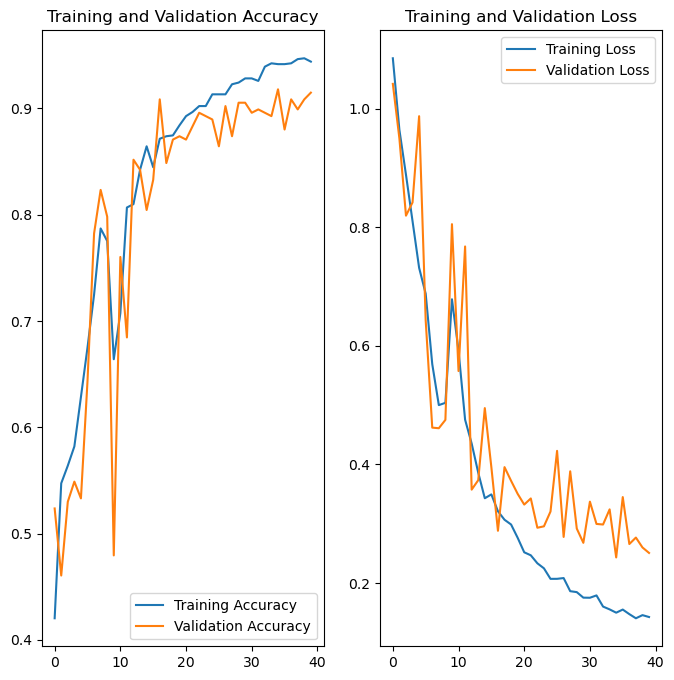

In [35]:
#get train accuracy in history
acc = history.history['accuracy']
#get validation accuracy
val_acc = history.history['val_accuracy']
# get train loss 
loss = history.history['loss']
#get validation loss
val_loss = history.history['val_loss']

epochs_range = range(epochs)
# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plot loss
plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
#make prediction with testing data
y_pred_class = model_class.predict(X_test_class)
y_pred_class = np.vectorize(predict)(y_pred_class)

10/10 [==============================] - 1s 112ms/step


In [40]:
#get accuracy
accuracy_score(y_test_class,y_pred_class)

0.9116719242902208

In [47]:
#save model
model_class.save("class_prediction_ver2.keras")

# Define function for prediction making

In [41]:
def predictions(file_url,model_class,model_fresh):
    #load image from url and prepare data
    img = cv2.imread(file_url) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    img = cv2.resize(img, (img_height, img_width))
    plt.imshow(img)
    plt.show()
    img = np.expand_dims(img, axis=0)
    #fruit type prediction
    class_prediction = model_class.predict(img)
    class_probabilities = class_prediction[0]
    class_predict = np.vectorize(predict)(class_probabilities)
    if class_predict[0] == 1:
        class_type = 'Peach'
    elif class_predict[1]==1:
        class_type='Pomegranate'
    else:
        class_type='Strawberry'
    #frest/rotten prediction
    fresh_probability = model_fresh.predict(img)[0][0]
    fresh_predict = predict(fresh_probability)
    fresh_predict = 'Fresh' if fresh_predict==1 else 'Rotten'
    print(f'class: {class_type} - confident: {class_probabilities}\nquality: {fresh_predict} - confident: {fresh_probability}')
    #return fruit type, fresh/rotten prediction with probability
    return class_probabilities,class_type,fresh_probability,fresh_predict

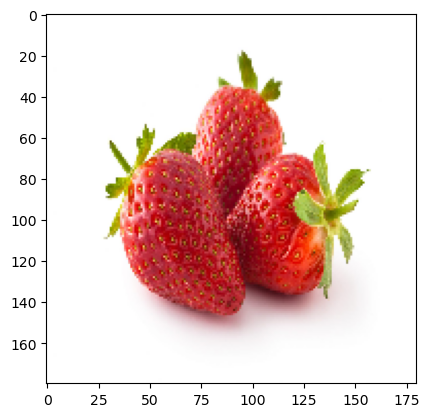

1/1 [==============================] - 1s 711ms/step
class: Strawberry - confident: [1.2915535e-27 5.3254427e-17 1.0000000e+00]
quality: Fresh - confident: 0.8927685022354126


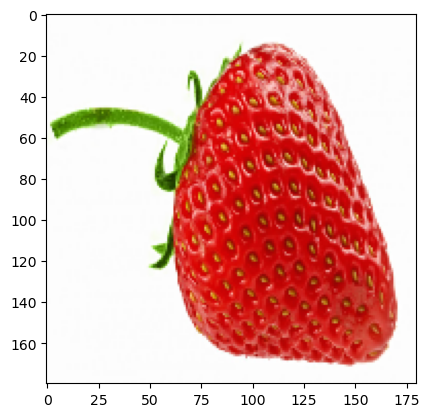

1/1 [==============================] - 0s 216ms/step
class: Strawberry - confident: [0.0000000e+00 1.1556576e-21 1.0000000e+00]
quality: Fresh - confident: 0.995021641254425


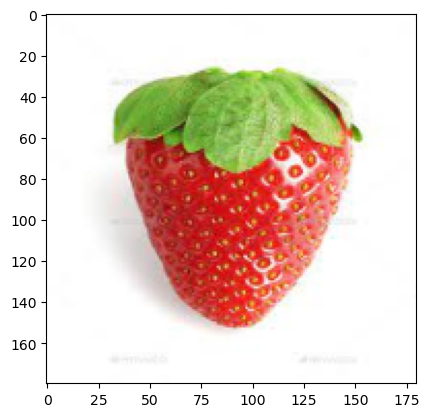

1/1 [==============================] - 0s 287ms/step
class: Strawberry - confident: [2.7986670e-25 6.7128896e-16 1.0000000e+00]
quality: Fresh - confident: 1.0


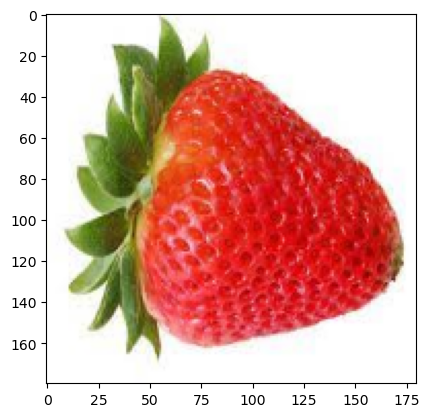

1/1 [==============================] - 0s 250ms/step
class: Strawberry - confident: [1.3124384e-19 2.1749807e-11 1.0000000e+00]
quality: Fresh - confident: 0.9985256195068359


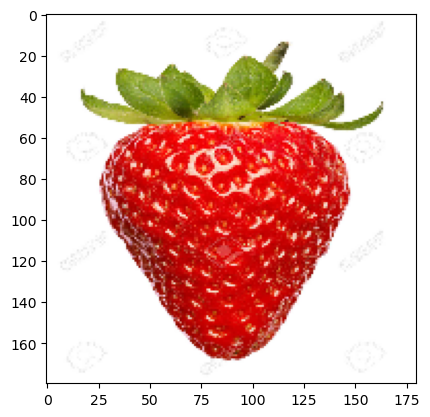

1/1 [==============================] - 0s 219ms/step
class: Strawberry - confident: [0.000000e+00 3.534869e-23 1.000000e+00]
quality: Fresh - confident: 0.9999938011169434


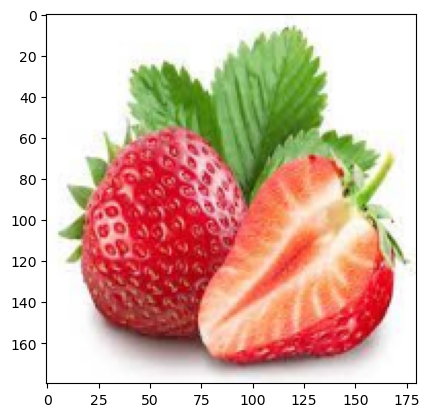

1/1 [==============================] - 0s 203ms/step
class: Strawberry - confident: [7.697913e-18 3.474027e-10 1.000000e+00]
quality: Fresh - confident: 1.0


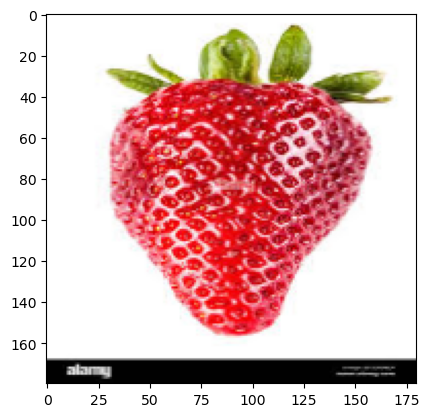

1/1 [==============================] - 0s 196ms/step
class: Strawberry - confident: [0.000000e+00 4.931548e-24 1.000000e+00]
quality: Fresh - confident: 0.9944270253181458


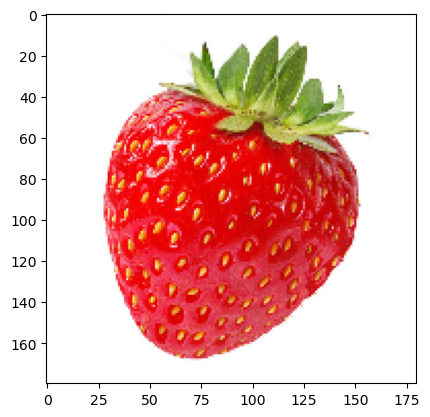

1/1 [==============================] - 0s 200ms/step
class: Strawberry - confident: [0.0000000e+00 2.9960253e-22 1.0000000e+00]
quality: Fresh - confident: 0.999995768070221


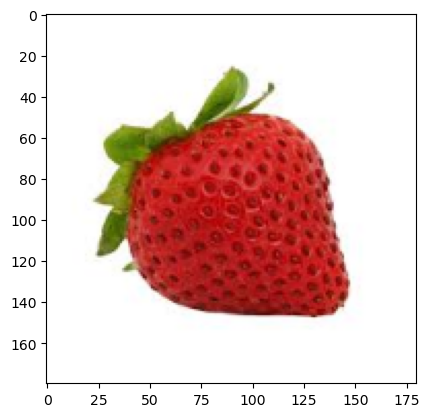

1/1 [==============================] - 0s 194ms/step
class: Strawberry - confident: [1.0348778e-14 7.6788407e-09 1.0000000e+00]
quality: Fresh - confident: 0.9988881945610046


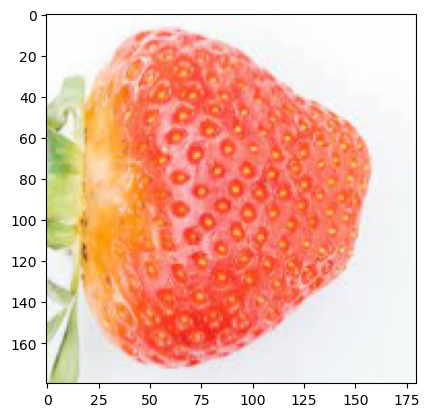

1/1 [==============================] - 0s 210ms/step
class: Peach - confident: [0.8071357  0.14613783 0.04672648]
quality: Fresh - confident: 0.9555408954620361


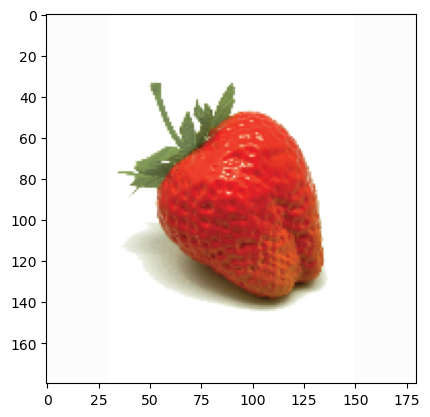

1/1 [==============================] - 0s 254ms/step
class: Strawberry - confident: [8.3113377e-11 1.2583476e-07 9.9999988e-01]
quality: Fresh - confident: 0.6855490803718567


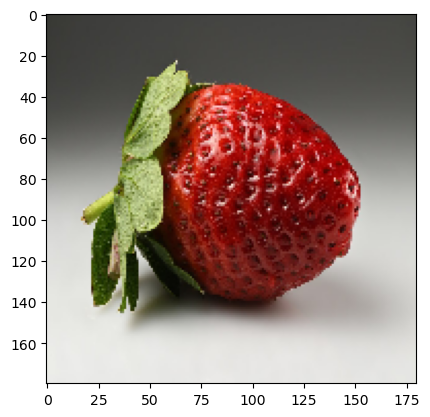

1/1 [==============================] - 0s 266ms/step
class: Strawberry - confident: [2.4600358e-17 8.8464759e-08 9.9999988e-01]
quality: Rotten - confident: 0.02439679205417633


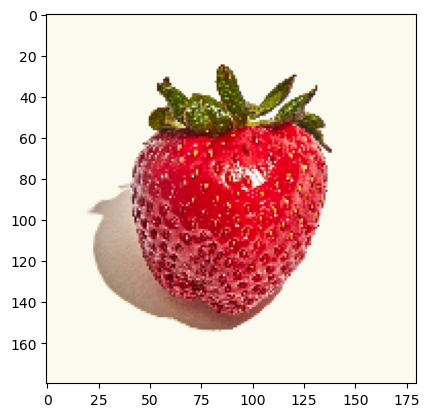

1/1 [==============================] - 0s 188ms/step
class: Strawberry - confident: [2.6921648e-29 7.1298225e-16 1.0000000e+00]
quality: Fresh - confident: 0.8910195827484131


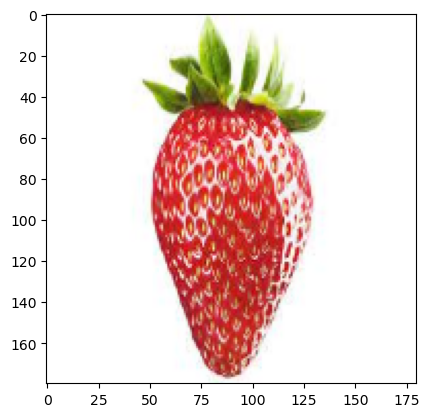

1/1 [==============================] - 0s 207ms/step
class: Strawberry - confident: [4.7348002e-30 2.7630986e-17 1.0000000e+00]
quality: Fresh - confident: 0.5406882166862488


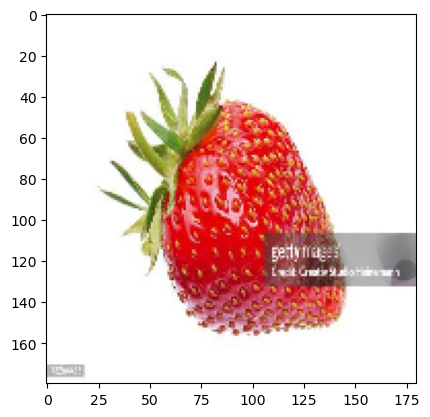

1/1 [==============================] - 0s 241ms/step
class: Strawberry - confident: [4.3155696e-33 2.6989947e-20 1.0000000e+00]
quality: Fresh - confident: 0.5370805263519287


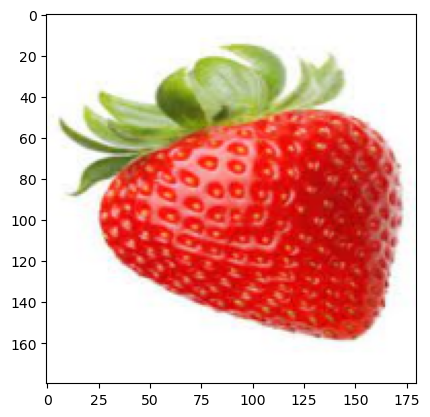

1/1 [==============================] - 0s 233ms/step
class: Strawberry - confident: [1.589874e-28 1.324390e-16 1.000000e+00]
quality: Fresh - confident: 0.9995427131652832


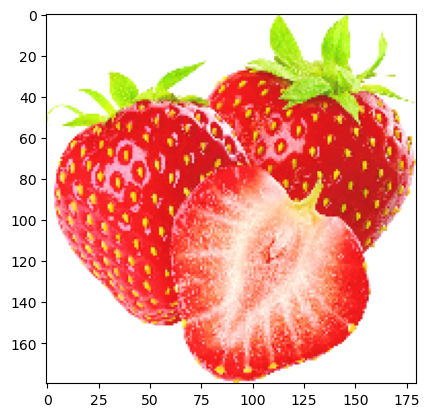

1/1 [==============================] - 0s 263ms/step
class: Strawberry - confident: [0.0000000e+00 4.2258512e-20 1.0000000e+00]
quality: Rotten - confident: 0.27471476793289185


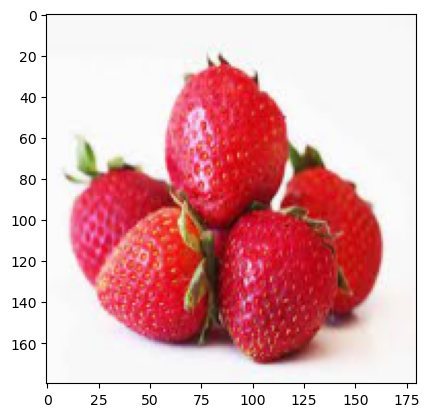

1/1 [==============================] - 0s 310ms/step
class: Strawberry - confident: [8.9463112e-15 1.0786908e-06 9.9999893e-01]
quality: Fresh - confident: 0.8202763795852661


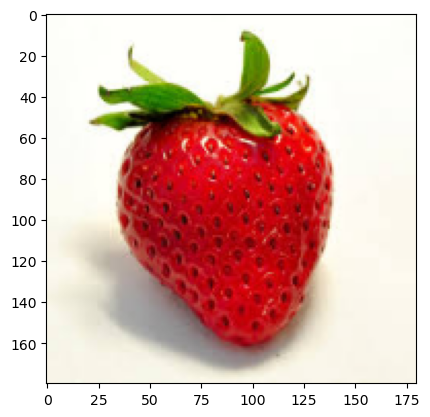

1/1 [==============================] - 0s 263ms/step
class: Strawberry - confident: [3.053467e-19 9.840189e-10 1.000000e+00]
quality: Fresh - confident: 0.9999786019325256


In [76]:
#test with data collected from the internet
folder = 'fresh_strawberries'
model_fresh = keras.models.load_model("fresh_prediction_ver4.keras")
model_class = keras.models.load_model("class_prediction_ver2.keras")
for file in os.listdir('test_data/'+folder):
        predictions('test_data/'+folder+"/"+file,model_class,model_fresh)